### Introduction

This notebook compares the annotated results of the "blocked" vs. "random" dataset of wikipedia talk pages. The "blocked" dataset consists of the few last comments before a user is blocked for personal harassment. The "random" dataset randomly samples all of the wikipedia talk page revisions. Both of these datasets are cleaned and filtered to remove common administrator messages. These datasets are annotated via crowdflower to measure friendliness, aggressiveness and whether the comment constitutes a personal attack. Below we plot a histogram of the results, pull out a few comments to examine, and compute inter-annotator agreement.

On Crowdflower, each revision is rated 7 times. The raters are given three questions:

1. Is this comment not English or not human readable?
    * Column 'na'
2. How aggressive or friendly is the tone of this comment? 
    * Column 'how_aggressive_or_friendly_is_the_tone_of_this_comment'
    * Ranges from 1 (Friendly) to 7 (Aggressive)
3. Is this an example of harassment or a personal attack?
    * Column 'is_harassment_or_attack'

### Loading packages and data

In [1]:
%matplotlib inline
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)

In [3]:
# Download data from google drive (Respect Eng / Wiki Collab): wikipdia data/v2_annotated
blocked_dat = pd.read_csv('../data/annotated_1k_no_admin_blocked_user_post_sample.csv')
random_dat = pd.read_csv('../data/annotated_1k_no_admin_post_sample.csv')

In [4]:
# Removing irrelevant differing columns
del blocked_dat['na_gold']
del random_dat['unnamed_0']

In [5]:
blocked_dat['dat_type'] = 'blocked'
random_dat['dat_type'] = 'random'

In [6]:
# Do both arrays now have the same columns?
(random_dat.columns == blocked_dat.columns).all()

True

In [7]:
dat = pd.concat([blocked_dat, random_dat])

In [8]:
# Remove test questions
dat = dat[dat['_golden'] == False]

In [9]:
# Replace missing data with 'False'
dat = dat.replace(np.nan, False, regex=True)

In [10]:
# Reshape the data for later analysis
def create_column_of_counts_from_nums(df, col):
    return df.apply(lambda x: int(col) == x)

In [11]:
aggressive_columns = ['1', '2', '3', '4', '5', '6', '7']

In [12]:
for col in aggressive_columns:
    dat[col] = create_column_of_counts_from_nums(dat['how_aggressive_or_friendly_is_the_tone_of_this_comment'], col)

In [13]:
blocked_columns = ['0','1']

In [14]:
for col in blocked_columns:
    dat['blocked_'+col] = create_column_of_counts_from_nums(dat['is_harassment_or_attack'], col)

In [15]:
blocked_columns = ['blocked_0','blocked_1']

In [16]:
# Group the data
agg_dict = dict.fromkeys(aggressive_columns, 'sum')
agg_dict.update(dict.fromkeys(blocked_columns, 'sum'))
agg_dict.update({'clean_diff': 'first', 'is_harassment_or_attack': 'mean', 
                                           'how_aggressive_or_friendly_is_the_tone_of_this_comment': 'mean', 'na': 'mean'})
grouped_dat = dat.groupby(['dat_type','rev_id'], as_index=False).agg(agg_dict)

In [17]:
# Get rid of data which the majority thinks is not in English or not readable
grouped_dat = grouped_dat[grouped_dat['na'] < 0.5]

### Plot histogram of average ratings by comment

For each revision, we take the average of all the ratings by level of harassment. The histogram of these averages for both the blocked and random dataset are displayed below. We notice that the blocked dataset has a significantly higher proportion of attacking comments (approximately 20%).

In [18]:
def hist_comments(df, bins, dat_type, plot_by, title):
    sliced_array = df[df['dat_type'] == dat_type][[plot_by]]
    weights = np.ones_like(sliced_array)/len(sliced_array)
    sliced_array.plot.hist(bins = bins, legend = False, title = title, weights=weights)
    plt.ylabel('Proportion')
    plt.xlabel('Average Score')

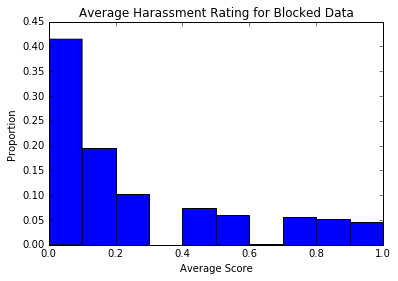

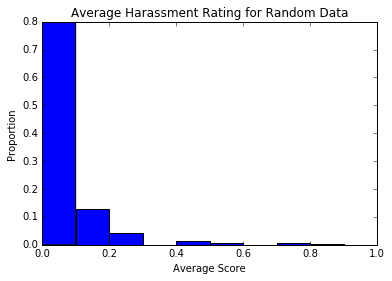

In [19]:
plt.figure()
bins = np.linspace(0,1,11)
hist_comments(grouped_dat, bins, 'blocked', 'is_harassment_or_attack', 'Average Harassment Rating for Blocked Data')
hist_comments(grouped_dat, bins, 'random', 'is_harassment_or_attack', 'Average Harassment Rating for Random Data')

For each revision, we take the average of all the ratings by level of friendliness/aggressiveness. The histogram of these averages for both the blocked and random dataset are displayed below. We notice that the blocked dataset has a more even distribution of aggressiveness scores.

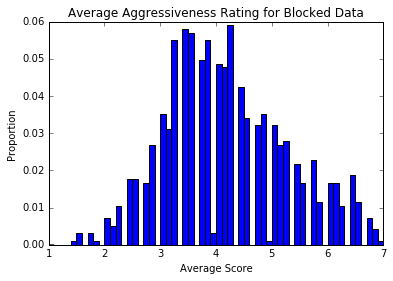

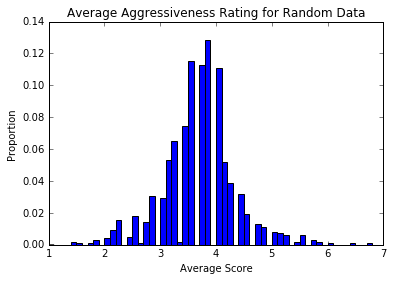

In [20]:
bins = np.linspace(1,7,61)
plt.figure()
hist_comments(grouped_dat, bins, 'blocked', 'how_aggressive_or_friendly_is_the_tone_of_this_comment', 
              'Average Aggressiveness Rating for Blocked Data')
hist_comments(grouped_dat, bins, 'random', 'how_aggressive_or_friendly_is_the_tone_of_this_comment', 
              'Average Aggressiveness Rating for Random Data')

### Selected harassing and aggressive comments by quartile

We look at a sample of revisions whose average aggressive score falls into various quantiles. This allows us to subjectively evaluate the quality of the questions that we are asking on Crowdflower. This slicing is done on the aggregate of both the blocked and random dataset.

In [21]:
def sorted_comments(df, sort_by, is_ascending, quartile, num, dat_type = None):
    if dat_type:
        sub_df = df[df['dat_type'] == dat_type]
    else:
        sub_df = df
    n = sub_df.shape[0]
    start_index = int(quartile*n)
    if dat_type:
        return sub_df[['clean_diff', 'is_harassment_or_attack', 
            'how_aggressive_or_friendly_is_the_tone_of_this_comment']].sort_values(
            by=sort_by, ascending = is_ascending)[start_index:start_index + num]
    return df[['clean_diff', 'dat_type', 'is_harassment_or_attack', 
        'how_aggressive_or_friendly_is_the_tone_of_this_comment']].sort_values(
        by=sort_by, ascending = is_ascending)[start_index:start_index + num]

Most harassing comments in aggregated dataset

In [22]:
sorted_comments(grouped_dat, 'is_harassment_or_attack', False, 0, 5)

clean_diff dat_type  is_harassment_or_attack  how_aggressive_or_friendly_is_the_tone_of_this_comment
133                                                                                                                                                                                                                                                                                                                                                        , oh shit, stop making warnings, motherfucker, also, fuck you.     blocked                        1                                                6.571429
409                                                                                                                                                                                                                                                                                                                                                                I wanted to let you know that Tymon.r. is a stupid moron.  blocked                        1                                                5.285714
552  Are you fucking serious? Again, what Hume have you read? Go fuck yourself, ignoramus. Stop trolling and spamming my talk page and spend the time actually getting an education and reading a book on philosophy for once in your life before you continue to make pointless, masturbatory edits on pages well beyond your comprehension. Please share, what is your interest i Hume beyond being a thorn in my side?     blocked                        1                                                6.571429
866                                                                                                                                                                                                                                                                                                                           you bitch why didn't you block kew gardens he also went past the 3 revert fucking rule god man  blocked                        1                                                6.000000
744                                                                                                                                                                                                                                                                                                                                                                         Hahahaha!!! \n\nFuck you! You are a Chinese pig!  blocked                        1                                                6.857143

Most aggressive comments in aggregated dataset

In [23]:
sorted_comments(grouped_dat, 'how_aggressive_or_friendly_is_the_tone_of_this_comment', False, 0, 5)

clean_diff dat_type  is_harassment_or_attack  how_aggressive_or_friendly_is_the_tone_of_this_comment
743                                                                                          Hahahaha!!! \n\nFuck you! You are a Chinese pig!  blocked                        1                                                7.000000
471   Hey fucking pig \n\nHey fucking pig-of-a-bully; I'll fuck off sure, but after you fuck out from Wikipedia completely you fucking bitch.  blocked                        1                                                6.857143
747                                                                                                                 Fuck you!!!You are a pig!  blocked                        1                                                6.857143
744                                                                                          Hahahaha!!! \n\nFuck you! You are a Chinese pig!  blocked                        1                                                6.857143
404                                                                                          Sucker \n\nYou suck the di*k of chicken fuc*ers.  blocked                        1                                                6.857143

Median aggressive comments in aggregated dataset

In [24]:
sorted_comments(grouped_dat, 'how_aggressive_or_friendly_is_the_tone_of_this_comment', False, 0.5, 5)

clean_diff dat_type  is_harassment_or_attack  how_aggressive_or_friendly_is_the_tone_of_this_comment
1891                                                                                                                                                                                Legacies of the Ancient World   random                 0.000000                                                3.857143
606                                                                       That may be, but at least I do not edit the pages of Wikipedia articles when I am unable to name a single work the author has wrote.     blocked                 0.142857                                                3.857143
400   Sounds an excellent idea to me, I would especially like amnesty on The Graceful Slick's talk page. Leave my modifications up forever and I will certainly be bored. 81.158.98.246  01:47, 31 May 2015 (UTC)  blocked                 0.000000                                                3.857143
1289                                                                                                                                                                                      Message from  Alwoodley   random                 0.000000                                                3.857143
1709                                                                                                                                              i like wwe this is what is latest brock vs seth at battleground   random                 0.000000                                                3.857143

Least aggressive comments in aggregated dataset

In [25]:
sorted_comments(grouped_dat, 'how_aggressive_or_friendly_is_the_tone_of_this_comment', True, 0, 5)

clean_diff dat_type  is_harassment_or_attack  how_aggressive_or_friendly_is_the_tone_of_this_comment
298                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 Merci Beaucoup \n\nA very kind thank you, Geraldine.  blocked                        0                                                1.428571
1196                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         You are most gracious and kind, thank you. \n\nThank you. Much appreciated. I should like to take you up on inquiries at a later date, though I am most grateful for your offer today.:0)))   random                        0                                                1.428571
1191                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        Thank you very much! Cheers!   random                        0                                                1.428571
336    (UTC)\nInserting citations\nHi Ariel,\n\nhere is the code now:\n http://angielittlefield.com/ebooks/TomThomsonTorontoNeighbourhoods.pdf Indeed, Thomson painted a number of watercolours between 1904 and 1909.http://www.tomthomsoncatalogue.org/catalogue/index.php?pageNum=0 \nokay step one is erase the two cn tags\n\nstep two - in front of the http insert thus   step three - athe end of the url ref put this   \nI will go correct the first one. Then please you try correcting the second one, and I am sure you will go perfect!  The article is shaping up quite well!  Congrats.  Please ask any questions here, and I will answer them for you.  You may also email me from the link at the top of my talk page, or you can also post a note on my talk page.  I am glad to help!  I really enjoy collaborating with other editors! Just ask!   Cheers!       18:39, 27 May 2015  blocked                        0                                                1.571429
38                                             

### Selected revisions by multiple questions

In this section, we examine a selection of revisions by their answer to Question 3 ('Is this an example of harassment or a personal attack?') and sorted by aggression score. Again, this allows us to subjectively evaluate the quality of questions and responses that we obtain from Crowdflower.

In [26]:
# Least aggressive comments that are considered harassment or a personal attack
sorted_comments(grouped_dat[grouped_dat['is_harassment_or_attack'] > 0.5], 'how_aggressive_or_friendly_is_the_tone_of_this_comment', True, 0, 5)

clean_diff  \
1257                                                                                                                                                                                                                                                                                                                                                                                                                                                            Racist \n\nYou are a racist, and the only reason you still exist here is because you are the "safe" kind of racist. The kind that isn't white. You also have severe issues with insecurity, as you see the entire world against you and other Chinese, or Asians in general, and therefore you feel the need to constantly lash out at incorrectly perceived white and European "bias" and "pride" in all sorts of places where it is absent. If you were white and acting the exact same way against anything non-Western and/or non-white, you'd have been banned long ago.   
720   ok... that's fine you can take the U.S out of that part ,but if a device is released the following year or later it is  considered its SUCCESSOR hence why someone would put !st or 2nd etc..because you't have 2 deices be called absolutely the same thing because they're not , they have different hardware , software and spec and its from the same maker and family model hence why its referenced as 1st gen etc etc...so how do you explain apple's devices? lol...the clealy release a new iphone every year and other hardware makers do so as well..the word generation means something or someone of the same family but with newer hardware released or born later..in hardware its usually a yearly thing..but if you prefer a model number which is more specific i'm willing to compromise that, the point is you can't name it the smae thing if its not the same exact product, you have to put something to tell them apart and i don't think its enough to just put a year the said model was released (xxxx), ...   
814                                   It is cute how TheGracefulSlick came over to me in your defense. I guess a lackey will do anything to please their master. It is a shame the user did so because I have seen he has similar interests as you. Looks like you both have made several unnotable articles. Once I read through your pages, I'll turn to his as well. Sorry, as much as this seems impossible to believe, it isn't personal. However, after seeing page after page of irrelevant bands being added to the list of garage rock bands, I couldn't stand it anymore. Oh, by the way, if you slander me by calling me a sockpuppet again, I will report you, and you will be blocked, so choose words carefully if you want to at least comment at deletion pages. Also, if that Slick guy responds at those pages again, I can have you blocked for canvasing. Make sure he gets the memo, you really have a lot to learn about how Wikipedia works. How do you like my new username, I think it is most appropriate. Ta-ta.     
489   Oh, sure! That old chestnut… Ah, and to think I was about to ask if you had that idiom in Yankland—you own it!\nNow, listen up, American worm: I have 614 pages on my watchlist so far. I'd also ask you to keep in mind that I have incredible power.\nAlso, please, do not misunderstand my keeping out that edit on Juan Cole. It honestly was just that Mediaite (sp?) cannot be considered RS, as well you knew. I am not interested in defending that maggot—"Let's invade Libya! It will be totally cool!"—because Cole pronounces himself a person of the Left. If you want to fire reams of criticism into his article, be my guest. Truth told, there is already some embarrassingly precarious synth criticism of him inserted by me. I ought to snip it out, but I just can't find the time, you know?\nContinuing with Cole: I do think the bit about the "far right-wing Jews" is just the usual attempt at smear with antisemitism (he's a critic of Israel, as you know).

In [27]:
# Most aggressive comments that are NOT considered harassment or a personal attack
sorted_comments(grouped_dat[grouped_dat['is_harassment_or_attack'] < 0.5], 'how_aggressive_or_friendly_is_the_tone_of_this_comment', False, 0, 5)

clean_diff dat_type  is_harassment_or_attack  how_aggressive_or_friendly_is_the_tone_of_this_comment
746                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            I will fuck the whole wikipedia!!!  blocked                 0.428571                                                6.428571
618   Which part of this reply did you not understand? Replying when you cast aspersions at me and others is not "trolling". Calling this edit "a transparent attempt to bait me" is just bizarre. Think again about your definitions of trolling and baiting, please.   ???\nOr this one: I assume you would claim that "Political Horseshit not focused on improving the article" with the edit summary "Fuck this shit" is not "casting aspersions" (or, indeed, "trolling"!) - which is where the problems all began. You'd be wrong.   ???    blocked                 0.428571                                                6.000000
390                                                                                                                                                                                                                                                                                                                                                                                                                                          The Graceful Slick....\nIs non other than an ungraceful dick!81.153.48.177  23:19, 30 May 2015 (UTC)  blocked                 0.428571                                                6.000000
1228                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        nigga wut you lying croak dfavors my cousin so fuck u   random                 0.428571                                                5.857143
619                                                                                                                                                                                                                                                                                                                                               I don't give a fuck. I just want to point out that responding to you casting aspersions like the above, and your previous comment, and most of your recent comments in fact, is not baiting.     blocked                 0.428571                                                5.714286

### Inter-Annotator Agreement

Below, we compute the Krippendorf's Alpha, which is a measure of the inter-annotator agreement of our Crowdflower responses. We achieve an Alpha value of 0.489 on our dataset, which is relatively low. We have since decided to reframe our questions and have achieved a higher Alpha score (see Experiment v. 2).

In [28]:
def add_row_to_coincidence(o, row, columns):
    m_u = row.sum(1)
    for i in columns:
        for j in columns:
            if i == j:
                o[i][j] = o[i][j] + row[i]*(row[i]-1)/(m_u-1)
            else:
                o[i][j] = o[i][j] + row[i]*row[j]/(m_u-1)
    return o

In [29]:
def make_coincidence_matrix(df, columns):
    df = df[columns]
    n = df.shape[0]
    num_cols = len(columns)
    o = pd.DataFrame(np.zeros((num_cols,num_cols)), index = columns, columns=columns)
    for i in xrange(n):
        o = add_row_to_coincidence(o, df[i:i+1], columns)
    return o

In [30]:
def binary_distance(i,j):
    return i!=j

def interval_distance(i,j):
    return (int(i)-int(j))**2

In [31]:
def e(n, i, j):
    if i == j:
        return n[i]*(n[i]-1)/sum(n)-1
    else:
        return n[i]*n[j]/sum(n)-1

def D_e(o, columns, distance):
    n = o.sum(1)
    output = 0
    for i in columns:
        for j in columns:
            output = output + e(n,i,j)*distance(i,j)
    return output

def D_o(o, columns, distance):
    output = 0
    for i in columns:
        for j in columns:
            output = output + o[i][j]*distance(i,j)
    return output

In [32]:
def Krippendorf_alpha(df, columns, distance = binary_distance, o = None):
    if o is None:
        o = make_coincidence_matrix(df, columns)
    d_o = D_o(o, columns, distance)
    d_e = D_e(o, columns, distance)
    return (1 - d_o/d_e)

In [33]:
df = grouped_dat[grouped_dat['dat_type'] == 'blocked']

In [34]:
Krippendorf_alpha(df, aggressive_columns, distance = interval_distance)

0.4886315361459096

In [35]:
Krippendorf_alpha(df, blocked_columns)

0.40970574161297302

In [36]:
df = grouped_dat[grouped_dat['dat_type'] == 'random']

In [37]:
Krippendorf_alpha(df, aggressive_columns, distance = interval_distance)

0.30144840760255176

In [38]:
Krippendorf_alpha(df, blocked_columns)

0.19031696568901457